In [1]:
import xarray as xr
import numpy  as np
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import proplot as plot

从mask后的数据计算每月的情况，将13年的4-8月绘制热图比较<br>

此处简单地做了个减法

remains:绘制更多统计量的

为了方便不更换变量名，用计算后的变量rmsd复制到此前的vr_mean上<br>
对于RMSD的计算还存疑，是先进行了直接做差之后的平方，之后在平均之后开根，类似于每个空间pattern做了一个RMSD，在每个时间维度上，这里需不需要提前对空间pattern做月平均？

0328
    
    修改为先进行月平均图的计算之后再进行空间pattern的RMSD的计算

08.18
-   修改为更大范围下的六个区域的计算

In [2]:
# 确定绘制的种类

partial_list = ["NE", "NC", "NWC", "YZ", "SC","SW"]
seasons_list = ['am', 'jja']
bias_dict = {}
rmsd_dict = {}
corr_dict = {}

bias_table = {}
rmsd_table = {}
corr_table = {}

for season in seasons_list:
    
    bias_region_dict = {}
    rmsd_region_dict = {}
    corr_region_dict = {}
    
    bias_region_table = {}
    rmsd_region_table = {}
    corr_region_table = {}
    
    for region in partial_list:

        # 读取数据
        main_path = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_t2m/"+region+"/interannual/"

        dir_vr = main_path + season +"_mask_mean_t2m_98-17_VR.nc"
        ds_vr = xr.open_dataset(dir_vr)
        # ds_vr

        # dir_rcm = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/pre/" + "daily_pre_03-15.nc"
        dir_rcm = main_path + season + "_mask_mean_t2m_98-17_RCM.nc"
        ds_rcm = xr.open_dataset(dir_rcm)
        # ds_rcm

        obs_cn051 = main_path + season + "_mask_sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
        ds_cn051 = xr.open_dataset(obs_cn051)

        # 整理数据

        obs_years_temp  = ds_cn051['tm']
        vr_years   = ds_vr['t2m'] - 273.15
        rcm_years  = ds_rcm['t2m'] - 273.15

        # rename coordinate name,和模式中的latitude longitude一样的经纬度坐标名
        # 05.06 t2m出现问题
        # rename_coords = dict(zip(obs_years.dims, vr_years.dims))
        # obs_years     = obs_years.rename(rename_coords)
        obs_years = xr.DataArray(obs_years_temp.values, dims = vr_years.dims, coords=vr_years.coords)

        # 计算RMSD，先取平方再开根
        vr_rmsd_temp  = (vr_years.values - obs_years.values)**2
        rcm_rmsd_temp = (rcm_years.values - obs_years.values)**2

        vr_rmsd_xr  = xr.DataArray(vr_rmsd_temp, coords = vr_years.coords)
        rcm_rmsd_xr = xr.DataArray(rcm_rmsd_temp, coords = rcm_years.coords)

        vr_rmsd  = np.sqrt(vr_rmsd_xr.mean(dim=["longitude","latitude"]))
        rcm_rmsd = np.sqrt(rcm_rmsd_xr.mean(dim=["longitude","latitude"]))

        # 计算BIAS
        vr_bias  =  vr_years.mean(dim=["longitude","latitude"]) - obs_years.mean(dim=["longitude","latitude"])
        rcm_bias = rcm_years.mean(dim=["longitude","latitude"]) - obs_years.mean(dim=["longitude","latitude"])

        # 计算空间pattern的corr
        vr_corr  = xr.corr(obs_years,  vr_years, dim=['latitude','longitude']).dropna(dim='Time')
        rcm_corr = xr.corr(obs_years, rcm_years, dim=['latitude','longitude']).dropna(dim='Time')

        # 合并到dict
        bias_region_dict[region] = {"vr":vr_bias, "rcm":rcm_bias} 
        rmsd_region_dict[region] = {"vr":vr_rmsd, "rcm":rcm_rmsd} 
        corr_region_dict[region] = {"vr":vr_corr, "rcm":rcm_corr}

        bias_region_table[region] = {"vr":vr_bias.mean().values, "rcm":rcm_bias.mean().values} 
        rmsd_region_table[region] = {"vr":vr_rmsd.mean().values, "rcm":rcm_rmsd.mean().values} 
        corr_region_table[region] = {"vr":vr_corr.mean().values, "rcm":rcm_corr.mean().values}
    
    # 合并到季节的dict
    bias_dict[season] = bias_region_dict
    rmsd_dict[season] = rmsd_region_dict
    corr_dict[season] = corr_region_dict

    bias_table[season] = bias_region_table
    rmsd_table[season] = rmsd_region_table
    corr_table[season] = corr_region_table

In [6]:
# 数据测试,简单把多年累计一下做一个小表
pd.DataFrame(bias_table['jja'])
# pd.DataFrame(rmsd_table['jja'])
# pd.DataFrame(corr_table['jja'])

,NE,NC,NWC,YZ,SC,SW
vr,0.3429125254179656,1.4487827095865906,2.3858874200845284,0.7901191680885411,-0.5570806455567258,-0.22911348153890537
rcm,0.23991199028229265,1.7097054011560284,2.9667077826975117,0.5701594194612204,-0.8395059775680082,-0.4061224207111458


绘制分区的结果

BIAS

进行折线图的尝试，但是不方便在一个年份上比较大小，所以考虑后面的柱状图

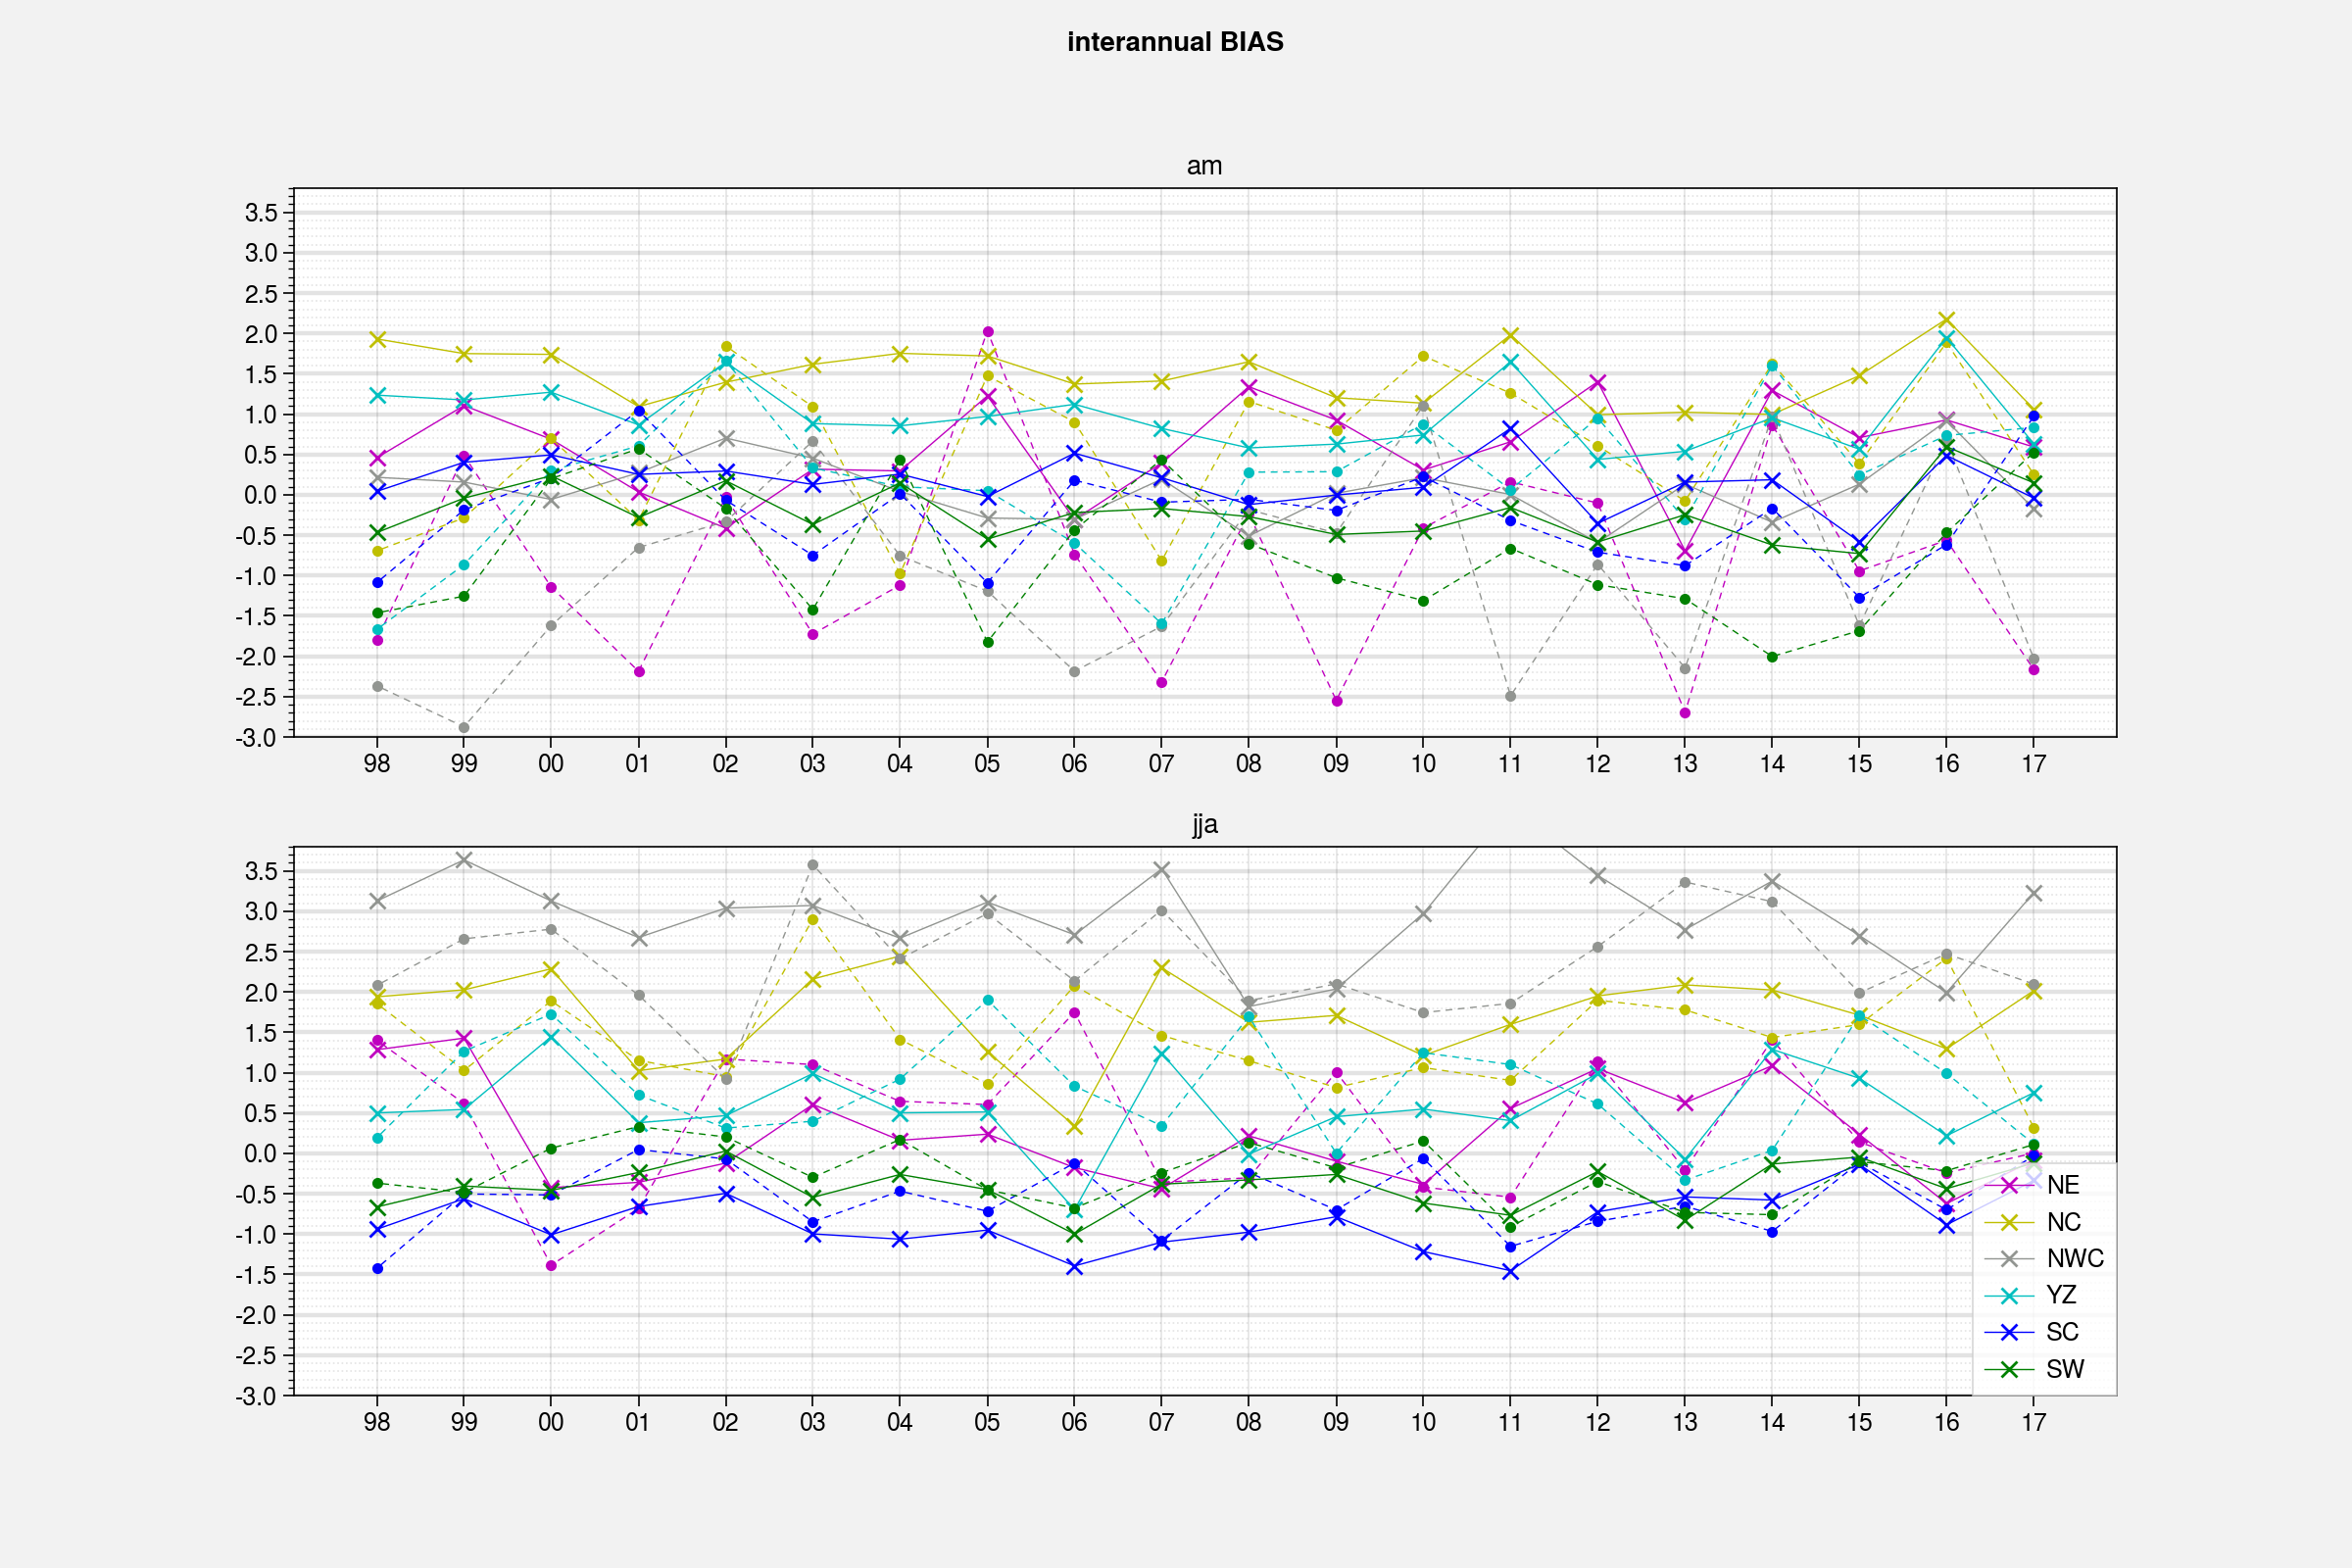

In [4]:
import matplotlib.dates as dates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# import matplotlib.pyplot as plt
# plt.style.use(['science', 'no-latex', 'cjk-tc-font'])
# plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展
fig,ax = plt.subplots(2,1,figsize=(12,8))
# loop region and seasons
# partial_list = ["NE", "NC", "YZ", "SW"] # loop region
partial_list = ["NE", "NC", "NWC", "YZ", "SC", "SW"] # loop region
seasons_list = ['am', 'jja']            # loop season
# loop region and seasons
# color_plot = ["m","y","c","g"]          # loop color
color_plot = ["m", "y", "gray", "c", "b", "g"]          # loop color
time_idx = pd.date_range(start = "1998-01-01", end = "2017-01-01",freq='AS') # add time coords


for iseason, season in enumerate(seasons_list):
    for iregion, region in enumerate(partial_list):

        plot_xr = bias_dict[season][region]['vr']
        ax[iseason].plot(time_idx, plot_xr, linestyle = (5, (5, 4)) , color =color_plot[iregion], marker = '.', linewidth = .5)
        plot_xr = bias_dict[season][region]['rcm']
        ax[iseason].plot(time_idx, plot_xr, linestyle = '-', color =color_plot[iregion], marker = 'x', label = region, linewidth = .5)

        ymin = -3.
        ymax = 3.8
        ax[iseason].set_ylim([ymin,ymax])

        # ax[iseason].set_xlim([xmin,xmax])
        # ax[iseason].xaxis.grid(True, which="minor", linestyle = ":")
        ax[iseason].xaxis.grid(True, which="major", linestyle = "-")
        ax[iseason].yaxis.grid(True, which="minor", linestyle = ":")
        ax[iseason].yaxis.grid(True, which="major", linestyle = "-", linewidth = 1.6)

        ax[iseason].yaxis.set_major_locator(MultipleLocator(0.5))
        ax[iseason].yaxis.set_minor_locator(MultipleLocator(0.1))
        ax[iseason].yaxis.set_major_formatter(FormatStrFormatter('%3.1f'))

        # ax[iseason].set_ylabel()
        # ax[iseason].get_legend().remove()
        ax[iseason].xaxis.set_minor_locator(dates.YearLocator())
        ax[iseason].xaxis.set_minor_formatter(dates.DateFormatter('%y'))
        ax[iseason].xaxis.set_major_locator(dates.YearLocator())
        ax[iseason].xaxis.set_major_formatter(dates.DateFormatter('%y'))
        
        ax[iseason].set_title(season)

ax[1].legend(loc = 'lower right')
plt.suptitle("interannual BIAS")
plt.savefig("./output_pic/t2m_bias_interannual_6region.png", dpi = 300, facecolor = "white")